# Learning objectives
By the end of this session, learners should be able to:
1. Learn how to split land use data into relevant use cases and rasterize the land use data for further analysis.
2. Acquire skills in preprocessing SPOT satellite imagery, including the creation of NDVI and NDWI indices, as well as adjusting data types for efficient processing.
3. Learn how to stack multiple SPOT images to build a composite image for analysis.
4. Gain practical experience in dividing large remote sensing images into smaller, manageable 224 x 224 patch images.
5. Be able to visualize both SPOT image patches and land use patches to understand the data structure.
6. Learn how to compute mean and standard deviation for each band in the SPOT images to prepare the dataset for further machine learning or deep learning tasks.

## 1. Splitting land use data into use cases and rasterizing

In [1]:
%%time

import os
import pandas as pd
import geopandas as gpd

lu_shp_path = "/home/jovyan/shared/2025_THA_LDD_training/SPOT/B/GT/gt_LU2019B.shp"

gdf = gpd.read_file(lu_shp_path)
print("No of rows:",len(gdf))
print("CRS:",gdf.crs)

gdf.head()

No of rows: 2654
CRS: EPSG:32648
CPU times: user 995 ms, sys: 1.02 s, total: 2.02 s
Wall time: 792 ms


,OBJECTID,LU_ID_L1,LU_ID_L2,LU_ID_L3,LU_CODE,LU_DES_TH,LU_DES_EN,LUL1_CODE,LUL2_CODE,LU_DES,Shape_Area,RAI,CLASS,geometry
0,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,31798.032924,20,1,"POLYGON ((302501.519 1850601.41, 302260.892 18..."
1,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,691.682240,0,1,"POLYGON ((303634.647 1850618.316, 303632.923 1..."
2,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,996328.251371,623,1,"POLYGON ((294108.634 1850691.792, 294061.911 1..."
3,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,738.949023,0,1,"POLYGON ((303655.52 1850713.5, 303651.136 1850..."
4,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,27427.133282,17,1,"POLYGON ((300522.573 1850678.779, 300514.118 1..."


### Splitting into LU use cases:

| Land Use | Raster Value | Color Code | Remarks |
|----------|----|----|----------|
| Urban | 1 | red |
| Agricultural | 2 | yellow | non-Para rubber, non-Oil palm classes |
| Forest | 3 | green |
| Water | 4 | blue |
| Oil Palm | 5 | purple |
| Para Rubber | 6 | pink |
| Others | 0 | black | all other classes 

### Encoding the Land use classes

In [2]:
final_lu_code = []
final_lu_class = []

for row in gdf.itertuples():
    if row.LU_DES_EN == 'Para rubber':
        final_lu_code.append(6)
        final_lu_class.append("PRB")

    elif row.LU_DES_EN == 'Oil palm':
        final_lu_code.append(5)
        final_lu_class.append("OIL")

    elif row.LUL1_CODE == 'W':
        final_lu_code.append(4)
        final_lu_class.append("WTR")

    elif row.LUL1_CODE == 'F':
        final_lu_code.append(3)
        final_lu_class.append("FOR")

    elif row.LUL1_CODE == 'A':
        final_lu_code.append(2)
        final_lu_class.append("AGR")

    elif row.LUL1_CODE == 'U':
        final_lu_code.append(1)
        final_lu_class.append("URB")

    else:
        final_lu_code.append(0)
        final_lu_class.append("X")

gdf['final_lu_code'] = final_lu_code
gdf['final_lu_class'] = final_lu_class

gdf.head()

,OBJECTID,LU_ID_L1,LU_ID_L2,LU_ID_L3,LU_CODE,LU_DES_TH,LU_DES_EN,LUL1_CODE,LUL2_CODE,LU_DES,Shape_Area,RAI,CLASS,geometry,final_lu_code,final_lu_class
0,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,31798.032924,20,1,"POLYGON ((302501.519 1850601.41, 302260.892 18...",2,AGR
1,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,691.682240,0,1,"POLYGON ((303634.647 1850618.316, 303632.923 1...",2,AGR
2,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,996328.251371,623,1,"POLYGON ((294108.634 1850691.792, 294061.911 1...",2,AGR
3,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,738.949023,0,1,"POLYGON ((303655.52 1850713.5, 303651.136 1850...",2,AGR
4,13,2.0,21.0,2101.0,A101,นาข้าว,Active paddy field,A,A1,None,27427.133282,17,1,"POLYGON ((300522.573 1850678.779, 300514.118 1...",2,AGR


### Rasterize land use (LU) data based on a given SPOT satellite image
Note: Rasterization is the process of converting vector data (such as polygons representing land use classes) into a raster format (a grid of pixels)

In [3]:
%%time
import rasterio as rio
from rasterio.features import rasterize

# define reference raster path
spot_imgs_path = "/home/jovyan/shared/2025_THA_LDD_training/SPOT/B/SPOT/img_SPOT2020B.tif"

with rio.open(spot_imgs_path) as ref_raster:
    # get the details of the reference raster
    crs = ref_raster.crs
    transform = ref_raster.transform
    width = ref_raster.width
    height = ref_raster.height
    dtype = ref_raster.dtypes[0]

# check if gdf and spot image have the same crs
print("SPOT CRS:",crs)
print("LU CRS:",gdf.crs)

# if crs is not the same
if gdf.crs != crs:
    print("CRS mismatch, reprojecting")
    gdf = gdf.to_crs(crs)
    print("Updated LU CRS:",gdf.crs)

# set the output raster path
output_raster_path = "/home/jovyan/shared/Dan/THA Space-AI training materials/Khon-kaen/lu_B_raster.tif"

with rio.open(output_raster_path, 'w', driver='GTiff',
                   count=1, dtype=dtype, crs=crs,
                   width=width, height=height, transform=transform) as dst:

    rasterized = rasterize(
        ((geom, value) for geom, value in zip(gdf.geometry, gdf['final_lu_code'])),
        out_shape=(height, width),
        transform=transform,
        fill=0,  # Fill value for empty pixels
        dtype=dtype
    )
    
    # Write the rasterized data to the output raster
    dst.write(rasterized, 1)

SPOT CRS: EPSG:4326
LU CRS: EPSG:32648
CRS mismatch, reprojecting
Updated LU CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
CPU times: user 936 ms, sys: 241 ms, total: 1.18 s
Wall time: 8.43 s


### Visualizing rasterized land use data

Raster CRS: EPSG:4326


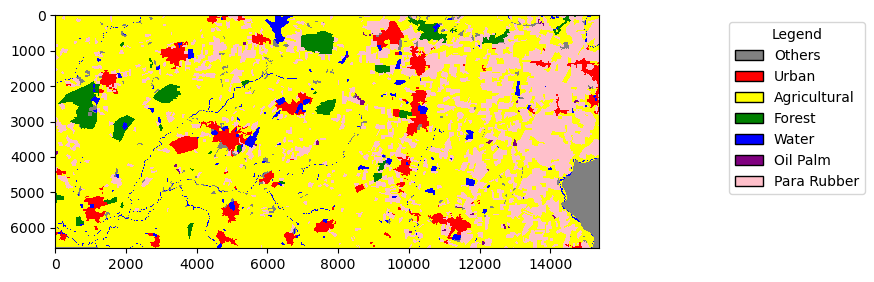

CPU times: user 1.02 s, sys: 421 ms, total: 1.44 s
Wall time: 1.21 s


In [4]:
%%time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Step 1: read the raster file
raster_path = "/home/jovyan/shared/Dan/THA Space-AI training materials/Khon-kaen/lu_B_raster.tif"

with rio.open(raster_path) as src:
    raster_data = src.read(1) #read just the 1st band
    crs = src.crs
     
print("Raster CRS:",crs) #check the coordinate reference system of the raster file
    
# Step 2: define the colormap
# Colors are assigned based on value / Landuse type
value_to_color = {
    0:'gray',
    1:'red',
    2:'yellow',
    3:'green',
    4:'blue',
    5:'purple',
    6:'pink'}

# create a colormap with these values
colors = [value_to_color.get(i,'black') for i in range(0,max(value_to_color.keys()) + 1)]
cmap = ListedColormap(colors)

# Step 3: Display the raster with the colormap
plt.figure(figsize=(10,10))
plt.imshow(raster_data,cmap=cmap,interpolation='none')

# Step 4: Add legend
# define the raster value and corresponding land use type
lu_legend = {0:'Others',
             1:'Urban',
             2:'Agricultural',
             3:'Forest',
             4:'Water',
             5:'Oil Palm',
             6:'Para Rubber'}

legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                   for value, color in value_to_color.items()]
plt.legend(handles=legend_elements, title="Legend", loc='upper right', bbox_to_anchor=(1.5, 1))

# show the plot
plt.tight_layout()
plt.show()

## 2. Preprocessing SPOT image

## Setting up the working directory and file paths

In [7]:
place_name='Khon-kaen' 
output_folder= "/home/jovyan/shared/Dan/THA Space-AI training materials/Khon-kaen"
spot_images_folder_path = "/home/jovyan/shared/2025_THA_LDD_training/SPOT/B/SPOT" 
landuse_path= "/home/jovyan/shared/Dan/THA Space-AI training materials/Khon-kaen/lu_B_raster.tif"

### Calculate NDVI and NDWI indicies from SPOT image and stack multiple images

In [ ]:
import glob
import rasterio
import numpy as np

def calculate_indices(image_path):
    with rasterio.open(image_path) as src:
        red = src.read(1).astype(float)
        green = src.read(2).astype(float)
        blue = src.read(3).astype(float)
        nir = src.read(4).astype(float)
        meta = src.meta
    epsilon = 1e-10
    ndvi = (nir - red) / (nir + red + epsilon)
    ndwi = (green - nir) / (green + nir + epsilon)
    
    return ndvi, ndwi, meta

def process_and_stack_images(folder_path, output_path):
    # Get all multiband images
    image_files = sorted(glob.glob(os.path.join(folder_path, "*.tif")))
    
    if len(image_files) != 3:
        raise ValueError(f"Expected 3 images, found {len(image_files)}")
    
    print(f"Found {len(image_files)} images: {image_files}")
    all_bands = []
    for image_path in image_files:
        print(f"Processing {image_path}...")
        with rasterio.open(image_path) as src:
            bands = [src.read(i) for i in range(1, 5)]  
            meta = src.meta
        ndvi, ndwi, _ = calculate_indices(image_path)
        all_bands.extend(bands + [ndvi, ndwi])
    
    meta.update({
        'count': len(all_bands),  #18 bands total(6 bands × 3 images)
        'dtype': 'float32'
    })
    os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
    print(f"Saving stacked image to {output_path}...")
    with rasterio.open(output_path, 'w', **meta) as dst:
        for idx, band in enumerate(all_bands, start=1):
            dst.write(band.astype(np.float32), idx)
    print("Done with calculating and stacking all bands!")
    
## It may take upto 5 min to calculate indices and stack image
stacked_spot_image =os.path.join(output_folder,"stack/18_band_spot_b.tif" ) # give file name to stack image
process_and_stack_images(spot_images_folder_path, stacked_spot_image )

Found 3 images: ['/home/jovyan/shared/2025_THA_LDD_training/SPOT/B/SPOT/img_SPOT2016B.tif', '/home/jovyan/shared/2025_THA_LDD_training/SPOT/B/SPOT/img_SPOT2020B.tif', '/home/jovyan/shared/2025_THA_LDD_training/SPOT/B/SPOT/img_SPOT2022B.tif']
Processing /home/jovyan/shared/2025_THA_LDD_training/SPOT/B/SPOT/img_SPOT2016B.tif...
Processing /home/jovyan/shared/2025_THA_LDD_training/SPOT/B/SPOT/img_SPOT2020B.tif...
Processing /home/jovyan/shared/2025_THA_LDD_training/SPOT/B/SPOT/img_SPOT2022B.tif...
Saving stacked image to /home/jovyan/shared/Dan/THA Space-AI training materials/Khon-kaen/stack/18_band_spot_b.tif...


## 3. Splitting into 224 x 224 patch images


### Importing necessary libraries

In [ ]:
import rasterio as rio
from rasterio.mask import mask
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from shapely.geometry import box
import os
import numpy as np
from tqdm import tqdm

### Extract the bounding box (extent) from the reference raster file and Clip the source_path raster to match the reference extent.

In [ ]:
def clip_to_reference_extent(source_path, reference_path, output_path):
    print(f"Clipping {os.path.basename(source_path)} to reference extent...")
    # Get reference image extent
    with rio.open(reference_path) as ref:
        ref_bounds = ref.bounds
        ref_bbox = box(ref_bounds.left, ref_bounds.bottom, ref_bounds.right, ref_bounds.top)
        ref_gdf = gpd.GeoDataFrame({'geometry': [ref_bbox]}, crs=ref.crs)
    
    # Clip source to reference extent
    with rio.open(source_path) as src:
        ref_gdf = ref_gdf.to_crs(src.crs)
        out_image, out_transform = mask(src, ref_gdf.geometry, crop=True)
        
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        with rio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)
    print("Clipping completed!")

### Create training patches of size 224*224 for both spot image and landuse image

 **Calculate the number of patches required along the width (x) and height (y) of the raster.**
- Divide the raster dimensions by the patch size and round up to ensure full coverage.
- Calculate the total number of patches (total_patches).

**Fine-Tuning Pre-trained Models**:

Using 224x224 patches ensures that the satellite image patches can directly serve as input for models like the Prithvi model or other pre-trained architectures without additional resizing, preserving details.

In [ ]:
def create_patches(image_path, output_dir, patch_size=224):
    with rio.open(image_path) as src:
        # Calculate number of patches
        num_patches_x = int(np.ceil(src.width / patch_size))
        num_patches_y = int(np.ceil(src.height / patch_size))
        total_patches = num_patches_y * num_patches_x
        
        print(f"Creating {total_patches} patches for {os.path.basename(image_path)}...")
        
        # Create progress bar
        pbar = tqdm(total=total_patches, desc="Creating patches")
        
        for y in range(num_patches_y):
            for x in range(num_patches_x):
                # Define window for current patch
                window = Window(x * patch_size, y * patch_size, patch_size, patch_size)
                transform = rio.windows.transform(window, src.transform)
                patch = src.read(window=window)
                profile = src.profile.copy()
                profile.update({
                    'height': patch.shape[1],
                    'width': patch.shape[2],
                    'transform': transform
                })
                
                # Use same naming pattern for both landuse and spot patches
                patch_name = f"patch_{x:03d}_{y:03d}.tif"
                output_path = os.path.join(output_dir, patch_name)
                
                with rio.open(output_path, 'w', **profile) as dest:
                    dest.write(patch)
                
                pbar.update(1)
        
        pbar.close()
    print(f"Patch creation completed for {os.path.basename(image_path)}!")

### Process images

- Create directories for storing land use and SPOT image patches.
- Align the land use raster to the extent of the SPOT imagery using the clip_to_reference_extent function.
- Create patches for both the clipped land use raster and SPOT imagery using the create_patches function.

In [ ]:
def process_images(landuse_path, spot_path, output_base_dir):
    print("Starting image processing...")
    
    # Create output directories
    landuse_patches_dir = os.path.join(output_base_dir, 'landuse_patches')
    spot_patches_dir = os.path.join(output_base_dir, 'spot_patches')
    os.makedirs(landuse_patches_dir, exist_ok=True)
    os.makedirs(spot_patches_dir, exist_ok=True)
    
    # 1. First clip landuse to spot extent
    clipped_landuse_path = os.path.join(output_base_dir, 'clipped_landuse.tif')
    clip_to_reference_extent(landuse_path, spot_path, clipped_landuse_path)
    
    # 2. Create patches for both images
    create_patches(clipped_landuse_path, landuse_patches_dir)
    create_patches(spot_path, spot_patches_dir)
    
    print("Image processing completed successfully!")

This script processes land use and SPOT imagery for the region specified by the place_name variable (khon-kaen in this case). It aligns the land use raster to the SPOT imagery's extent and resolution, and then divides both datasets into smaller patches for further analysis.

In [ ]:
%%time

process_images(
    landuse_path=landuse_path, # File path of the landuse image
    spot_path=stacked_spot_image,
    output_base_dir=output_folder
)

## Filter the patches created above as some of them might not be clipped to 224*224 size

Ensure all images in a folder are of the required size (224x224 pixels).

In [ ]:
def filter_patch_images(image_folder):
    desired_width, desired_height = 224, 224
    deleted_files = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
    
    for image_file in tqdm(image_files, desc="Processing Images", unit="image"):
        image_path = os.path.join(image_folder, image_file)
        try:
            with rasterio.open(image_path) as src:
                width, height = src.width, src.height
                if (width, height) != (desired_width, desired_height):
                    os.remove(image_path)
                    deleted_files.append(image_file)
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
    
    print("\nSummary:")
    print(f"Total images processed: {len(image_files)}")
    print(f"Images deleted: {len(deleted_files)}")
    if deleted_files:
        print("Deleted files:")
        for file in deleted_files:
            print(f"- {file}")

In [ ]:
%%time

landuse_patch_folder = os.path.join(output_folder,'landuse_patches')
spot_patch_folder = os.path.join(output_folder,'spot_patches')
filter_patch_images(spot_patch_folder)
filter_patch_images(landuse_patch_folder)

### Split the patches into train, test, and validation set

This process is essential for training machine learning models, where datasets are divided into different subsets for training, validating, and evaluating the model's performance.



In [ ]:
%%time
import os
import shutil
import random
from pathlib import Path
import numpy as np

def create_train_val_test_splits(
    image_dir, 
    mask_dir, 
    output_dir,
    train_ratio=0.70,  # 70% of the data will be used for training.
    val_ratio=0.10,    # 10% of the data will be used for validation.
    test_ratio=0.20,   # 20% of the data will be used for testing.
    random_seed=42
):

    # Set random seed
    random.seed(random_seed)
    np.random.seed(random_seed)
    splits = ['train', 'val', 'test']
    for split in splits:
        for subdir in ['images', 'masks']:
            os.makedirs(os.path.join(output_dir, split, subdir), exist_ok=True)
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    random.shuffle(image_files)
    
    total_size = len(image_files)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)

    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]
    
    def copy_files(file_list, split_name):
        print(f"\nCopying {split_name} files...")
        for filename in file_list:
            src_image = os.path.join(image_dir, filename)
            dst_image = os.path.join(output_dir, split_name, 'images', filename)
            shutil.copy2(src_image, dst_image)
            src_mask = os.path.join(mask_dir, filename)
            dst_mask = os.path.join(output_dir, split_name, 'masks', filename)
            shutil.copy2(src_mask, dst_mask)
    
    split_files = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }
    
    for split_name, files in split_files.items():
        copy_files(files, split_name)
        print(f"{split_name} split: {len(files)} images")

    return {
        'train_size': len(train_files),
        'val_size': len(val_files),
        'test_size': len(test_files)
    }

In [ ]:
%%time

final_training_data_folder = os.path.join(output_folder,'final_training_data')

stats = create_train_val_test_splits(
    image_dir=spot_patch_folder,
    mask_dir=landuse_patch_folder,
    output_dir=final_training_data_folder,
    train_ratio=0.70,
    val_ratio=0.10,
    test_ratio=0.20,
    random_seed=42
)

print("\nData split summary:")
print(f"Total images: {sum(stats.values())}")
for split_name, size in stats.items():
    print(f"{split_name}: {size} images")

In [ ]:
!pwd

## Calculates the mean and standard deviation of pixel values for a dataset of raster images

Compute the mean and standard deviation for each channel (e.g., RGB or multispectral bands) across all images in the dataset.

In [ ]:
%%time

import numpy as np
import rasterio
from glob import glob

def calculate_dataset_statistics(image_paths):
    means = []
    stds = []
    
    for path in image_paths:
        with rasterio.open(path) as src:
            img = src.read()  # Shape: (channels, height, width)
            means.append(img.mean(axis=(1, 2)))
            stds.append(img.std(axis=(1, 2)))
    
    channel_means = np.mean(means, axis=0)
    channel_stds = np.mean(stds, axis=0)
    
    return channel_means, channel_stds


# image_paths = glob(os.path.join(final_training_data_folder,'train','images','*.tif'))
image_paths = glob(os.path.join(final_training_data_folder,'train/images','*.tif'))

means, stds = calculate_dataset_statistics(image_paths)
means_list = ", ".join(f"{mean:.5f}" for mean in means)
stds_list = ", ".join(f"{std:.5f}" for std in stds)

print("Channel means:", means_list)
print("Channel stds:", stds_list)